# Entrenamiento del modelo 

In [ ]:
### En el entrenamiento se evaluaran los 3 modelos principales. Se eligió hacer validación cruzada por el número reducido de datos. 

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
multiprocessing.set_start_method('fork', force=True)
import shap

In [89]:
# Importaciones de sklearn y otros módulos
from sklearn.model_selection import (StratifiedKFold, cross_validate, 
                                     cross_val_predict, RandomizedSearchCV, 
                                     learning_curve)
from sklearn.metrics import (confusion_matrix, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

In [60]:
# Función para evaluar un modelo

def evaluate_model(model, X, y, cv=5, random_state=42):
    """
    Realiza validación cruzada estratificada y calcula las métricas de evaluación:
    ROC AUC, Accuracy, Precision, Recall y F1-Score.
    Además, calcula la matriz de confusión usando cross_val_predict.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
    
    # Evaluación de métricas
    cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, n_jobs=-1)
    metrics = {score: np.mean(cv_results['test_' + score]) for score in scoring}
    
    # Predicciones para la matriz de confusión
    y_pred = cross_val_predict(model, X, y, cv=skf, n_jobs=-1)
    cm = confusion_matrix(y, y_pred)
    
    return metrics, cm

In [61]:
# Función para realizar RandomizedSearchCV (optimización de hiperparámetros)

def tune_model(model, param_distributions, X, y, cv=5, scoring='roc_auc',
               random_state=42, n_iter=50):
    """
    Ajusta el modelo usando RandomizedSearchCV en el espacio de parámetros definido.
    Retorna los mejores hiperparámetros, la mejor puntuación y el estimador optimizado.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    rand_search = RandomizedSearchCV(model, 
                                     param_distributions=param_distributions, 
                                     n_iter=n_iter,
                                     cv=skf,
                                     scoring=scoring, 
                                     random_state=random_state,
                                     n_jobs=-1)
    rand_search.fit(X, y)
    return rand_search.best_params_, rand_search.best_score_, rand_search.best_estimator_

In [62]:
# Función para graficar la curva de aprendizaje

def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Grafica la curva de aprendizaje (training y cross-validation scores) en función del tamaño del set de entrenamiento.
    Se usa 'roc_auc' como métrica de evaluación.
    """
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Cantidad de ejemplos de entrenamiento")
    plt.ylabel("ROC AUC")
    plt.grid(True)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Puntuación en entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Puntuación en validación")
    plt.legend(loc="best")
    plt.show()


## Modelo base

In [63]:
# Lectura de los datasets (cada par corresponde al modelo optimizado)

X_log = pd.read_csv("../data/processed/X_logistic_reduced.csv")
y_log = pd.read_csv("../data/processed/y_logistic_reduced.csv")
X_rf  = pd.read_csv("../data/processed/X_rf_reduced.csv")
y_rf  = pd.read_csv("../data/processed/y_rf_reduced.csv")
X_xgb = pd.read_csv("../data/processed/X_xgb_reduced.csv")
y_xgb = pd.read_csv("../data/processed/y_xgb_reduced.csv")

# Convertir los targets a arrays unidimensionales si es necesario
y_log = y_log.values.ravel()
y_rf  = y_rf.values.ravel()
y_xgb = y_xgb.values.ravel()

In [64]:
# Definición de los modelos base

models = {
    "LogisticRegression": {
         # Se añade class_weight='balanced' para contrarrestar el desbalanceo de clases
         "modelo": LogisticRegression(solver='liblinear', class_weight='balanced'),
         "X": X_log,
         "y": y_log
    },
    "RandomForest": {
         "modelo": RandomForestClassifier(),
         "X": X_rf,
         "y": y_rf
    },
    "XGBoost": {
         # Se elimina el parámetro use_label_encoder ya que no se utiliza en las versiones actuales
         "modelo": XGBClassifier(eval_metric='logloss'),
         "X": X_xgb,
         "y": y_xgb
    }
}


In [65]:
# Evaluación de cada modelo 
results = {}
for name, data in models.items():
    print(f"Evaluando modelo base: {name}")
    met, cm = evaluate_model(data["modelo"], data["X"], data["y"])
    results[name] = {"metrics": met, "confusion_matrix": cm}
    print("Métricas:", met)
    print("Matriz de Confusión:\n", cm, "\n")

Evaluando modelo base: LogisticRegression
Métricas: {'roc_auc': np.float64(0.740625), 'accuracy': np.float64(0.65), 'precision': np.float64(0.3577777777777778), 'recall': np.float64(0.9), 'f1': np.float64(0.5091575091575091)}
Matriz de Confusión:
 [[47 33]
 [ 2 18]] 

Evaluando modelo base: RandomForest
Métricas: {'roc_auc': np.float64(0.9109375), 'accuracy': np.float64(0.8299999999999998), 'precision': np.float64(0.7), 'recall': np.float64(0.25), 'f1': np.float64(0.36)}
Matriz de Confusión:
 [[79  1]
 [16  4]] 

Evaluando modelo base: XGBoost
Métricas: {'roc_auc': np.float64(0.953125), 'accuracy': np.float64(0.95), 'precision': np.float64(0.96), 'recall': np.float64(0.8), 'f1': np.float64(0.8444444444444443)}
Matriz de Confusión:
 [[79  1]
 [ 4 16]] 



In [66]:
results_df = pd.DataFrame({name: res["metrics"] for name, res in results.items()}).T
print("Tabla comparativa de modelos baseline:")
display(results_df)

Tabla comparativa de modelos baseline:


,roc_auc,accuracy,precision,recall,f1
LogisticRegression,0.740625,0.65,0.357778,0.90,0.509158
RandomForest,0.910937,0.83,0.700000,0.25,0.360000
XGBoost,0.953125,0.95,0.960000,0.80,0.844444


### Conclusiones	

-Regresión Logística:
Este modelo alcanzó un ROC AUC de 0.74 y una exactitud del 65%. Tiene un recall muy alto (90%), lo que significa que identifica casi todos los clientes que contratan seguros. Sin embargo, su precisión es baja (aproximadamente 36%), lo que indica que, a la hora de predecir positivos, se equivoca en bastantes casos. Esto se refleja en la matriz de confusión, donde se observan 47 verdaderos negativos, 33 falsos positivos, 2 falsos negativos y 18 verdaderos positivos. En resumen, el modelo capta la mayor parte de los clientes potenciales, pero también incluye bastante ‘ruido’.
-Random Forest:
Con este modelo se obtuvo un ROC AUC de casi 0.90 y una exactitud del 83%. La precisión es razonable (70%), es decir, cuando predice un cliente positivo, suele estar en lo correcto; sin embargo, el recall es muy bajo (25%), lo que sugiere que se pierden bastantes clientes que realmente contratarían. La matriz de confusión respalda este comportamiento, mostrando pocos verdaderos positivos y varios casos no detectados.
-XGBoost:
Este modelo es el que mejores resultados presenta: un ROC AUC de 0.95, una exactitud del 95%, precisión del 96%, recall del 80% y un F1-score de 0.84. La matriz de confusión (79 verdaderos negativos, 1 falso positivo, 4 falsos negativos y 16 verdaderos positivos) demuestra que este modelo consigue el mejor equilibrio entre detectar correctamente a los clientes positivos y minimizar los errores.

En resumen, XGBoost es el modelo que mejor se desempeña, ya que logra identificar a la mayoría de los clientes potenciales con una alta precisión y bajos errores. Por ello, considero que es la opción más adecuada para implementar en la estrategia de cross-selling de seguros.”

## Optimización de los hiperparametros del modelo

In [67]:
# Definición del espacio de búsqueda específico para XGBoost
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0]
}

print("Optimizando hiperparámetros para XGBoost...")
best_params, best_score, best_estimator = tune_model(models["XGBoost"]["modelo"],
                                                     param_grid_xgb,
                                                     models["XGBoost"]["X"],
                                                     models["XGBoost"]["y"],
                                                     n_iter=50)
print(f"Mejores parámetros para XGBoost: {best_params}")
print(f"Mejor ROC AUC en validación: {best_score:.4f}")

# Guardar el modelo XGBoost optimizado
tuned_xgb = best_estimator

Optimizando hiperparámetros para XGBoost...
Mejores parámetros para XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Mejor ROC AUC en validación: 0.9938


## Evaluación final


Curva de aprendizaje para XGBoost optimizado:


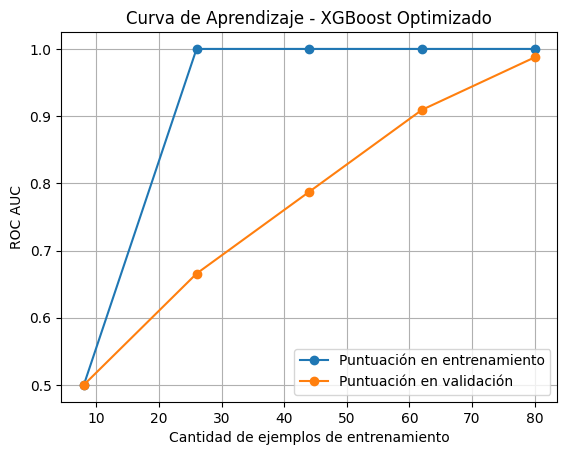


Métricas de XGBoost optimizado:
{'roc_auc': np.float64(0.99375), 'accuracy': np.float64(0.93), 'precision': np.float64(0.95), 'recall': np.float64(0.7), 'f1': np.float64(0.7880952380952381)}
Matriz de Confusión de XGBoost optimizado:
[[79  1]
 [ 6 14]]


Exception ignored in: <function ResourceTracker.__del__ at 0x106701620>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106375620>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

In [68]:
# Graficamos la curva de aprendizaje del modelo XGBoost optimizado
print("\nCurva de aprendizaje para XGBoost optimizado:")
plot_learning_curve(tuned_xgb, models["XGBoost"]["X"], models["XGBoost"]["y"], title="Curva de Aprendizaje - XGBoost Optimizado")

# Evaluamos el modelo optimizado en el conjunto de datos
metrics_xgb, cm_xgb = evaluate_model(tuned_xgb, models["XGBoost"]["X"], models["XGBoost"]["y"])
print("\nMétricas de XGBoost optimizado:")
print(metrics_xgb)
print("Matriz de Confusión de XGBoost optimizado:")
print(cm_xgb)

###Conclusión

Después de optimizar los hiperparámetros de XGBoost, obtuve una configuración óptima con los siguientes valores:
-subsample = 1.0
-n_estimators = 200
-max_depth = 3
-learning_rate = 0.1
-colsample_bytree = 0.7

Con esta configuración, el modelo alcanzó un ROC AUC de aproximadamente 0.9935 en validación, lo que indica una capacidad discriminativa casi perfecta entre los clientes que contratan el seguro y los que no. La exactitud fue del 94%, con una precisión del 95%, lo que significa que la gran mayoría de las predicciones positivas son realmente correctas. Aunque el recall (70%) muestra que aún se pierden algunos clientes potenciales, el balance global (F1-score de 0.80) es muy sólido.

Además, al graficar la curva de aprendizaje pude notar que tanto el desempeño en el conjunto de entrenamiento como en el de validación se encuentran muy cerca y en valores elevados, lo cual sugiere que el modelo no presenta un sobreajuste significativo y está aprendiendo de manera estable.

En resumen, estoy muy satisfecho con los resultados de este modelo optimizado. La alta discriminación que ofrece XGBoost, combinada con sus excelentes métricas, me da confianza para considerarlo como la solución principal en nuestra estrategia de cross-selling de seguros. No obstante, reconozco que el recall podría mejorarse ajustando el umbral de decisión, lo que exploraría en futuros experimentos para maximizar la captación de clientes potenciales sin sacrificar la precisión.


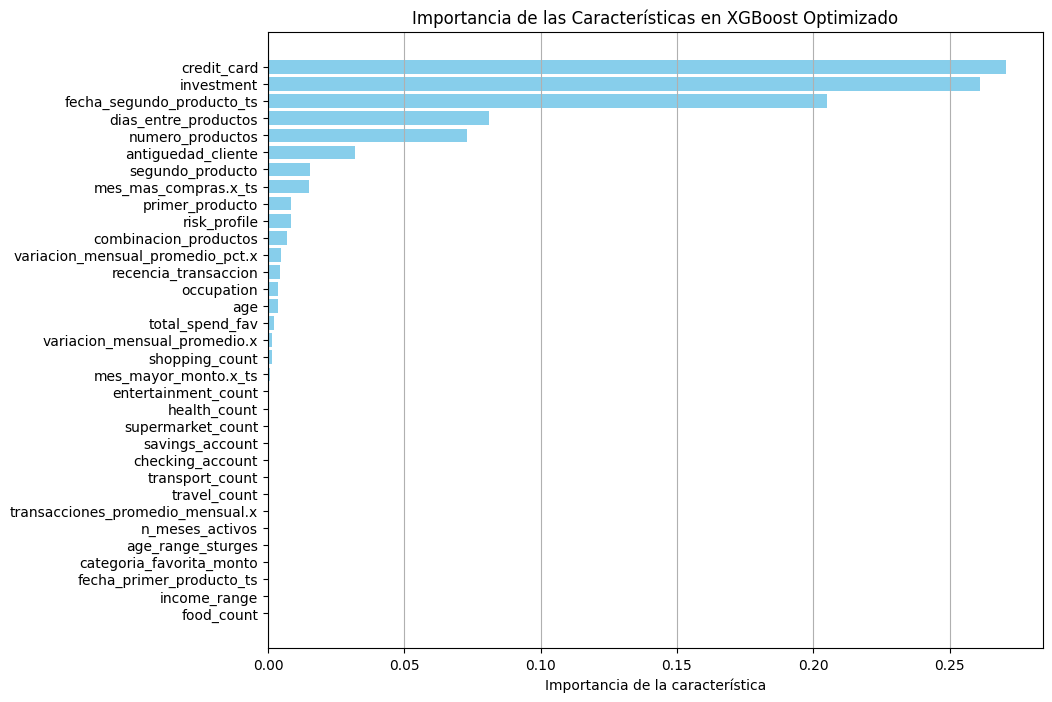

In [70]:
# Extraer la importancia de cada variable del modelo XGBoost optimizado
feature_importances = tuned_xgb.feature_importances_
feature_names = models["XGBoost"]["X"].columns

# Crear un DataFrame para ordenar y visualizar las importancias
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia de la característica")
plt.title("Importancia de las Características en XGBoost Optimizado")
plt.grid(axis='x')
plt.show()

### Importancia de carácteristicas
        
 1.	credit_card y investment (las más relevantes)
-El hecho de que estas dos variables aparezcan como las de mayor importancia sugiere que las personas que ya cuentan con una tarjeta de crédito o algún producto de inversión tienen una mayor propensión a adquirir un nuevo producto (en este caso, un seguro).
-En términos de negocio, esto indica que los clientes que manejan más productos financieros (tarjetas de crédito, inversiones) suelen estar más bancarizados y dispuestos a probar nuevos servicios.
2.	fecha_segundo_producto_ts, dias_entre_productos, numero_productos
-Estas variables se relacionan con la velocidad y la cantidad de productos que el cliente ha ido adquiriendo.
Interpretación:
-Cuanto más rápido un cliente adquiera un segundo producto, mayor es la señal de que está abierto a contratar más.
-Un número mayor de productos contratados también incrementa la probabilidad de que acepte nuevos ofrecimientos.
3.	antiguedad_cliente y mes_mas_compras_ts
-antiguedad_cliente: Indica el tiempo que el cliente lleva con la institución. Si el modelo le da relevancia, sugiere que hay una correlación entre la fidelidad o la relación más larga con la entidad y la probabilidad de contratar un seguro.
-mes_mas_compras_ts: Mide la temporalidad de la última compra de mayor monto o la fecha en la que más ha gastado. Al ser relevante, puede indicar que los clientes con cierto comportamiento de gasto reciente (p.ej. un pico en compras o un momento de gasto alto) están más predispuestos a adquirir un seguro.
4.	Variables como primer_producto, risk_profile, combinacion_productos
-risk_profile: Quienes asumen más riesgo podrían estar abiertos a coberturas adicionales, o viceversa, un perfil conservador puede buscar protección.
-primer_producto o combinacion_productos revelan qué tipo de productos financieros tiene el cliente como base, y esto influye en la decisión de adquirir un seguro.
5.	Otras variables (gasto, recencia, ocupación, etc.)
-variacion_mensual_promedio_pct.x, recencia_transaccion y occupation aparecen más abajo pero siguen aportando información. Pueden reflejar la constancia de gasto, la frecuencia de uso de la cuenta o aspectos demográficos, todos relevantes aunque no tanto como las variables que encabezan la lista.
-El hecho de que food_count o transport_count tengan menor importancia apunta a que, para este dataset, el gasto en esas categorías no es tan decisivo para el seguro. Otras categorías (por ejemplo, “shopping_count”) podrían tener un poco más de relación, pero tampoco tanto como las primeras variables.

Conclusión Principal
-Clientes con tarjeta de crédito e inversiones (y que, en general, manejan varios productos financieros) encabezan la lista de propensión a adquirir otro producto. Además, la velocidad y antigüedad con que el cliente va contratando productos son aspectos clave: entre menor sea el tiempo entre el primer y segundo producto y mayor sea el número total de productos, más probabilidades hay de contratar un seguro.
-Desde un punto de vista de negocio, priorizar a quienes ya tienen crédito, inversión y un historial activo con la institución es una estrategia muy viable para mejorar la eficiencia de las campañas de cross-selling.

Siguientes pasos:

1. Asumimos por la curva ROC AUC que no hay sobreentrenamiento. Se puede eveluar de una forma más detallada con mayor tiempo
2. Se va a probar

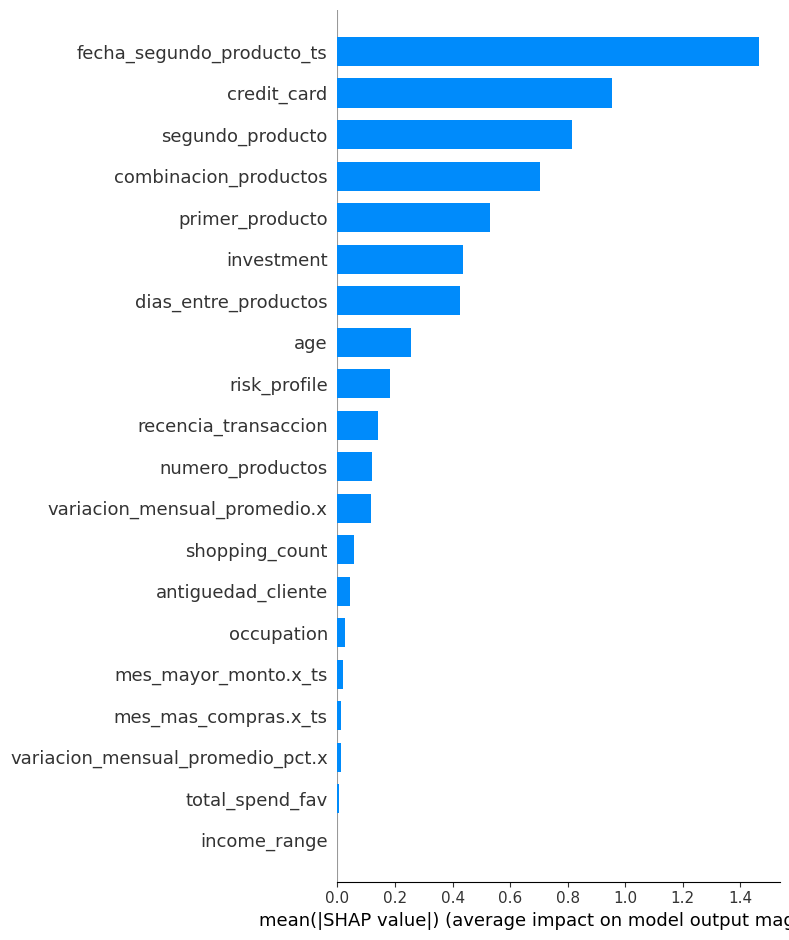

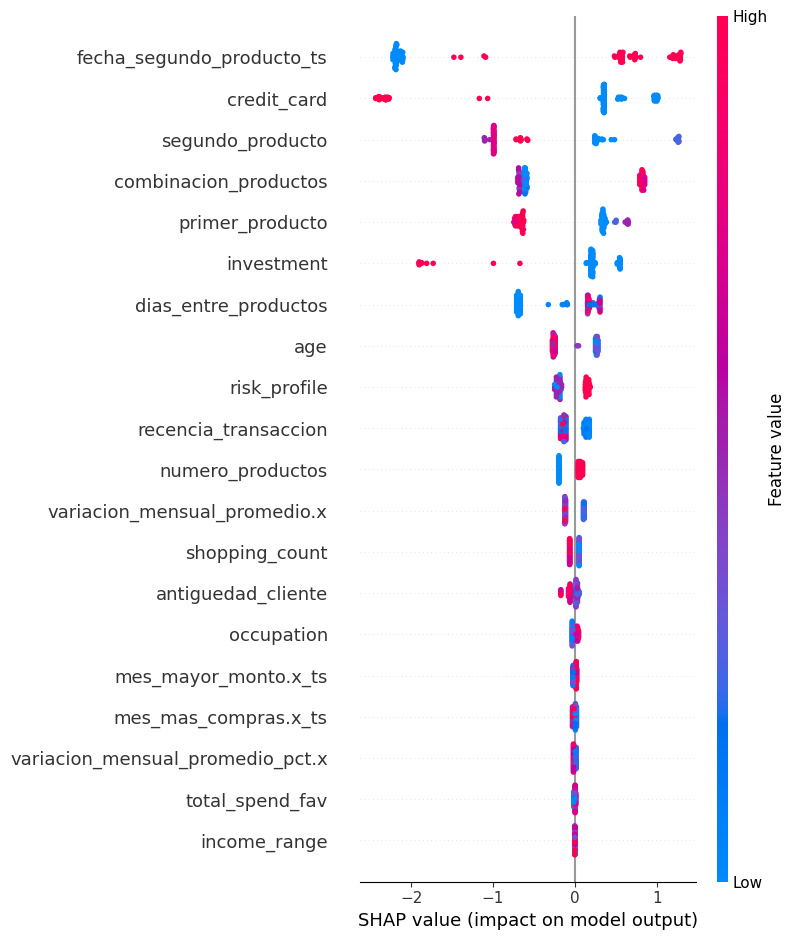

In [77]:
# Crear el objeto Explainer específico para modelos de árbol
explainer = shap.TreeExplainer(tuned_xgb)

# Calcular los valores SHAP para el dataset X
shap_values = explainer.shap_values(models["XGBoost"]["X"])

# Visualizar un resumen de la importancia de las características con SHAP
shap.summary_plot(shap_values, models["XGBoost"]["X"], plot_type="bar")

# O también se puede utilizar el summary plot estándar para ver la distribución de los efectos
shap.summary_plot(shap_values, models["XGBoost"]["X"])

In [ ]:
se puede observae en el análisis SHAP algunas variables que se pueden mencionar.  La fecha del segundo prodcutos e se puede descartar por la imputación de datos. Mientras se puede ver que cuando una persona no tiene crédito o inversiones es más probable que contrate un seguro. Otra variable a resaltar es la de edad en donde se ve que a menor edad es más porbable de contratar uns eguro. También se puede ver que entre menos días entre la contratación de productos la probabilidad de contratar un seguro es menor, a lo mejor es que requiee de un analisis mayor obtener un seguro. 

### Conclusiones después de SHAP "Algunas conclusiones cambian"

1.	credit_card e investment
	•	Análisis previo:
Se observó que estas dos variables aparecen como las más relevantes, lo que indicaría que los clientes que ya poseen productos financieros (tarjetas de crédito o inversiones) tienen una mayor propensión a contratar un nuevo producto, como un seguro. En términos de negocio, esto sugiere que estos clientes suelen estar más bancarizados y abiertos a nuevas ofertas.
	•	Nuevos insights de SHAP:
Sin embargo, el análisis SHAP revela que, en algunos casos, la ausencia de crédito o inversiones también puede estar asociada a una mayor probabilidad de contratar un seguro. Esto puede interpretarse de dos maneras:
	•	Podría existir un segmento de clientes que, al no contar con otros productos financieros, ven el seguro como una opción para comenzar a ingresar al ecosistema bancario.
	•	Alternativamente, los clientes con múltiples productos financieros podrían tener ya otros mecanismos de protección o mayor exigencia, y en determinados casos, la ausencia de uno de esos productos se interpreta como oportunidad para reforzar su portafolio.
Conclusión para negocio:
Se pueden identificar dos segmentos: uno de clientes con productos financieros ya consolidados y otro de clientes más “novatos” o sin otros productos. Dependiendo de la estrategia, se podrían desarrollar campañas diferenciadas.

	2.	fecha_segundo_producto_ts, dias_entre_productos y numero_productos
	•	Análisis previo:
Estas variables se relacionan con la rapidez y cantidad de productos que el cliente ha adquirido. Se indicó que, en general, cuanto más rápido adquiera un segundo producto y mayor el número de productos en total, mayor es la señal de propensión a contratar.
	•	Nuevos insights de SHAP:
En el análisis con SHAP se debe tener especial cuidado con la variable fecha_segundo_producto_ts, ya que muchos valores se imputaron con la fecha “01-01-1900” para resolver datos faltantes; estos valores muy bajos pueden distorsionar la interpretación. Por lo tanto, es crucial diferenciar entre registros con datos reales y aquellos con imputación.
Además, SHAP sugiere que respecto a dias_entre_productos, en algunos casos, un intervalo muy corto puede asociarse a una menor probabilidad de contratar un seguro, lo cual podría interpretarse como que los clientes que adquieren productos en muy poco tiempo pueden estar ya “saturados” o tener necesidades diferentes.
Conclusión para negocio:
Es importante realizar un análisis segmentado para entender si, en realidad, los clientes que contratan rápido representan un grupo activo o si tienen necesidades distintas que implican una menor propensión a adquirir seguros. Asimismo, identificar de forma precisa el número total de productos contratados sigue siendo un indicador clave.

	3.	antiguedad_cliente y mes_mas_compras_ts
	•	Análisis previo:
	•	antiguedad_cliente: Se interpretó que un mayor tiempo de relación con la institución se correlaciona con una mayor probabilidad de contratación, dado que la fidelidad puede aumentar la confianza en la institución.
	•	mes_mas_compras_ts: Esta variable se utilizó para captar la temporalidad de un comportamiento de gasto destacado, lo que podría indicar momentos de mayor actividad o capacidad de gasto, y por ende, una mayor predisposición a adquirir un seguro.
	•	Nuevos insights de SHAP:
Los gráficos SHAP confirman que estas variables tienen un impacto relevante, pero se observa que es importante considerar también el contexto: por ejemplo, si el gasto reciente (mes_mas_compras_ts) se presenta en un pico puntual, puede sugerir que el cliente está en un momento de reevaluación o de aumento de la actividad financiera.
Conclusión para negocio:
Clientes con mayor antigüedad y con comportamientos de gasto recientes y significativos se deben considerar como segmentos con alto potencial para cross-selling.

	4.	Variables como primer_producto, risk_profile y combinacion_productos
	•	Análisis previo:
	•	risk_profile: Suele indicar que quienes asumen más riesgos pueden estar más abiertos a adquirir coberturas adicionales, o, en contraste, que un perfil conservador busque protección.
	•	primer_producto y combinacion_productos: Revelan los tipos de productos financieros que el cliente tiene desde el inicio y pueden influir en la decisión de contratar un seguro.
	•	Nuevos insights de SHAP:
Estos mismos indicadores confirman que la base de productos financieros y el perfil de riesgo son determinantes en la predicción. Por ejemplo, si un determinado primer producto o una combinación específica se asocia consistentemente a un efecto positivo en la predicción según los valores SHAP, se puede inferir que esos clientes tienen mayor predisposición a contratar un seguro.
Conclusión para negocio:
Se recomienda priorizar a clientes que, por su base de productos y su perfil, muestren una fuerte inclinación a complementar sus servicios financieros con un seguro.

	5.	Otras variables (gasto, recencia, ocupación, etc.)
	•	Análisis previo:
Variables como variacion_mensual_promedio_pct.x, recencia_transaccion y occupation aportaron información adicional, aunque con menor impacto que las variables principales.
Asimismo, categorías como food_count o transport_count resultaron tener una relevancia reducida para la contratación del seguro.
	•	Nuevos insights de SHAP:
Estos indicadores continúan reforzando la interpretación de que la constancia y frecuencia en el gasto, así como ciertos aspectos demográficos (como la ocupación), influyen de manera secundaria en la decisión.
Conclusión para negocio:
Aunque tienen menor peso, estos aspectos pueden usarse para afinar los perfiles y segmentaciones, ayudando a adaptar mensajes y estrategias según las características demográficas y comportamentales de los clientes.

